In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h2o



In [39]:
#reading data and preprocessing

train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

raw_b = train_b

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')


def calculate_hourly_average(df, month, hour, column):
    print(f"Calculate index 1: {df.index}")
    same_time = df[(df['month'] == month) & (df['hour'] == hour)]



    years = df.index.year.unique()
    # Remove the current year from the list
    years = [yr for yr in years]

    values = []

    for year in years:
        values.extend(same_time[same_time.index.year == year][column].values)
    
    # Calculate the average using data from all available years
    if len(values) > 0:
        avg = np.nanmean(values)
    else:
        avg = np.nan  # Set the average to NaN if there are no valid values

    return avg



def preprocessing_X_train(data):
    if 'date_calc' in data.columns:
        data.drop('date_calc', axis=1, inplace=True)

    if 'date_forecast' in data.columns:
        data.set_index('date_forecast', inplace=True)

    data = data.groupby(pd.Grouper(freq='1H')).mean()
    data.dropna(how='all', inplace=True)

    data['snow_density:kgm3'].fillna(0.0, inplace=True)

    elevation_mapping = {
        6.0 : -1,
        7.0 : 0,
        24.0 : 1
    }

    data['elevation_flag'] = data['elevation:m'].map(elevation_mapping)
    data.drop(columns=['elevation:m'], inplace=True)

    data.rename_axis('time', inplace=True)

    

    return data

def preprocessing_combo_train(data):
    print(f"Combo index 1: {data.index}")

    full_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')

    missing_timestamps = full_range.difference(data.index)

    gaps_df = pd.DataFrame(missing_timestamps, columns=['missing_time'])



    # merge the new dataframe with the original dataframe
    data = pd.merge(data, gaps_df, left_index=True, right_on='missing_time', how='outer')

    data.drop(columns=['missing_time'], inplace=True, axis=1)

    
    print(f"Combo index 3: {data.index}")
    for column in data.columns:
        nan_rows = data[data[column].isna()]
        for idx, row in nan_rows.iterrows():
            month = row['month']
            hour = row['hour']
            avg = calculate_hourly_average(data, month, hour, column)
            data.at[idx, column] = avg



    return data

def preprocessing_combo_train_2(data):
    # Ensure the data's index is a DatetimeIndex
    assert isinstance(data.index, pd.DatetimeIndex), "Index should be of type DatetimeIndex"
    
    # Create a full range of timestamps
    full_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')
    data = data.reindex(full_range)
    
    # Extract hour and month for each timestamp
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    
    # Fill NaN values based on hourly average of the respective month
    for column in [col for col in data.columns if col not in ['hour', 'month']]:
        avg = data.groupby(['month', 'hour'])[column].transform('mean')
        data[column].fillna(avg, inplace=True)
        
    return data

def preprocessing_combo_train_5(data):
    # Ensure the data's index is a DatetimeIndex
    assert isinstance(data.index, pd.DatetimeIndex), "Index should be of type DatetimeIndex"

    # Create a full range of timestamps
    full_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')
    data = data.reindex(full_range)

    # Extract day, hour, month, and year for each timestamp
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['year'] = data.index.year

    # Iterate through the columns
    for column in [col for col in data.columns if col not in ['day', 'hour', 'month', 'year']]:
        for idx, row in data.iterrows():
            if pd.isna(row[column]):
                # Try to fill with data from the exact same day/hour in the previous year
                prev_year = row['year'] - 1
                same_day_hour_data = data[
                    (data['day'] == row['day']) &
                    (data['hour'] == row['hour']) &
                    (data['month'] == row['month']) &
                    (data['year'] == prev_year)
                ]
                if not same_day_hour_data.empty:
                    data.at[idx, column] = same_day_hour_data.iloc[0][column]
                else:
                    # If no data is available for the previous year on the same day/hour,
                    # fill with the hourly average of the respective month
                    avg = data[
                        (data['month'] == row['month']) &
                        (data['hour'] == row['hour'])
                    ][column].mean()
                    data.at[idx, column] = avg

    # Drop the auxiliary columns 'day' and 'year' used for filling
    data = data.drop(['day', 'year'], axis=1)

    return data

def preprocessing_X_test(data):
    if 'date_calc' in data.columns:
        data.drop('date_calc', axis=1, inplace=True)
    
    data['hour'] = data['date_forecast'].dt.hour
    data['month'] = data['date_forecast'].dt.month

    if 'date_forecast' in data.columns:
        data.set_index('date_forecast', inplace=True)

    data = data.groupby(pd.Grouper(freq='1H')).mean()
    data.dropna(how='all', inplace=True)
    
    data['snow_density:kgm3'].fillna(0.0, inplace=True)

    elevation_mapping = {
        6.0 : -1,
        7.0 : 0,
        24.0 : 1
    }

    data['elevation_flag'] = data['elevation:m'].map(elevation_mapping)
    data.drop(columns=['elevation:m'], inplace=True)

    
    data.interpolate(method='time', inplace=True)

    data.rename_axis('time', inplace=True)
    
    return data

def preprocessing_Y(data):
    if 'time' in data.columns:
        data.set_index('time', inplace=True)
    data.dropna(inplace=True)

    mask = (data['pv_measurement'] != 0) & (data['pv_measurement'] == data['pv_measurement'].shift(-1))

    for i in range(2, 4):
        mask = (data['pv_measurement'] != 0) & (data['pv_measurement'] == data['pv_measurement'].shift(-i))

    mask_diff_value = data['pv_measurement'] != data['pv_measurement']

    filtered_data = data[~(mask & ~mask_diff_value)]

    return filtered_data

def preprocessing_Y_test(data):
    if 'time' in data.columns:
        data.set_index('time', inplace=True)
    data.dropna(inplace=True)
    data = data.resample('1H').mean()
    data.dropna(inplace=True)

    return data

#combining observed and estimated data
x_train_a = pd.concat([X_train_observed_a, X_train_estimated_a], axis=0)
x_train_a = preprocessing_X_train(x_train_a)
y_train_a = preprocessing_Y(train_a)
x_train_a = x_train_a.merge(y_train_a, how='inner', on='time')

x_train_a.to_csv('proc_training_data_a.csv')



x_train_b = pd.concat([X_train_observed_b, X_train_estimated_b], axis=0)
x_train_b = preprocessing_X_train(x_train_b)
y_train_b = preprocessing_Y(train_b)
x_train_b = x_train_b.merge(y_train_b, how='inner', on='time')

x_train_b.to_csv('proc_training_data_b.csv')



x_train_c = pd.concat([X_train_observed_c, X_train_estimated_c], axis=0)
x_train_c = preprocessing_X_train(x_train_c)
y_train_c = preprocessing_Y(train_c)
x_train_c = x_train_c.merge(y_train_c, how='inner', on='time')

x_train_c.to_csv('proc_training_data_c.csv')

x_train = pd.concat([x_train_a, x_train_b, x_train_c], axis=0, ignore_index=True)
x_train = x_train.sample(frac=1, random_state=42).reset_index(drop=True)


x_train.tail()



,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,elevation_flag,pv_measurement
89644,5.25,1.24900,163.800003,0.00,0.000000,163.800003,0.0,274.399994,0.000000,0.000000,...,0.10,276.750000,96.175003,15714.150391,3.45,2.600,2.225,0.0,-1,0.00
89645,10.70,1.22550,962.799988,0.00,0.000000,306.450012,0.0,285.299988,0.000000,0.000000,...,0.25,285.549988,99.900002,2257.725098,8.75,8.450,-2.250,0.0,0,0.00
89646,4.60,1.27525,899.349976,1171572.75,334.674988,282.549988,0.0,272.500000,35.400002,115472.296875,...,0.40,273.774994,100.000000,15272.775391,8.15,6.875,-4.375,0.0,1,19.60
89647,9.35,1.23300,422.049988,860906.00,178.875000,422.049988,0.0,283.200012,61.625000,268279.562500,...,0.00,283.849976,81.099998,30918.300781,3.40,3.200,-1.250,0.0,-1,244.86
89648,5.75,1.26400,426.225006,0.00,0.000000,359.649994,0.0,275.750000,0.000000,0.000000,...,0.30,277.250000,100.000000,1765.849976,4.85,4.475,1.850,0.0,-1,0.00


(37944, 48)
(116929, 46)
(17576, 47)
Checkpoint 1
Checkpoint 2
Checkpoint 3


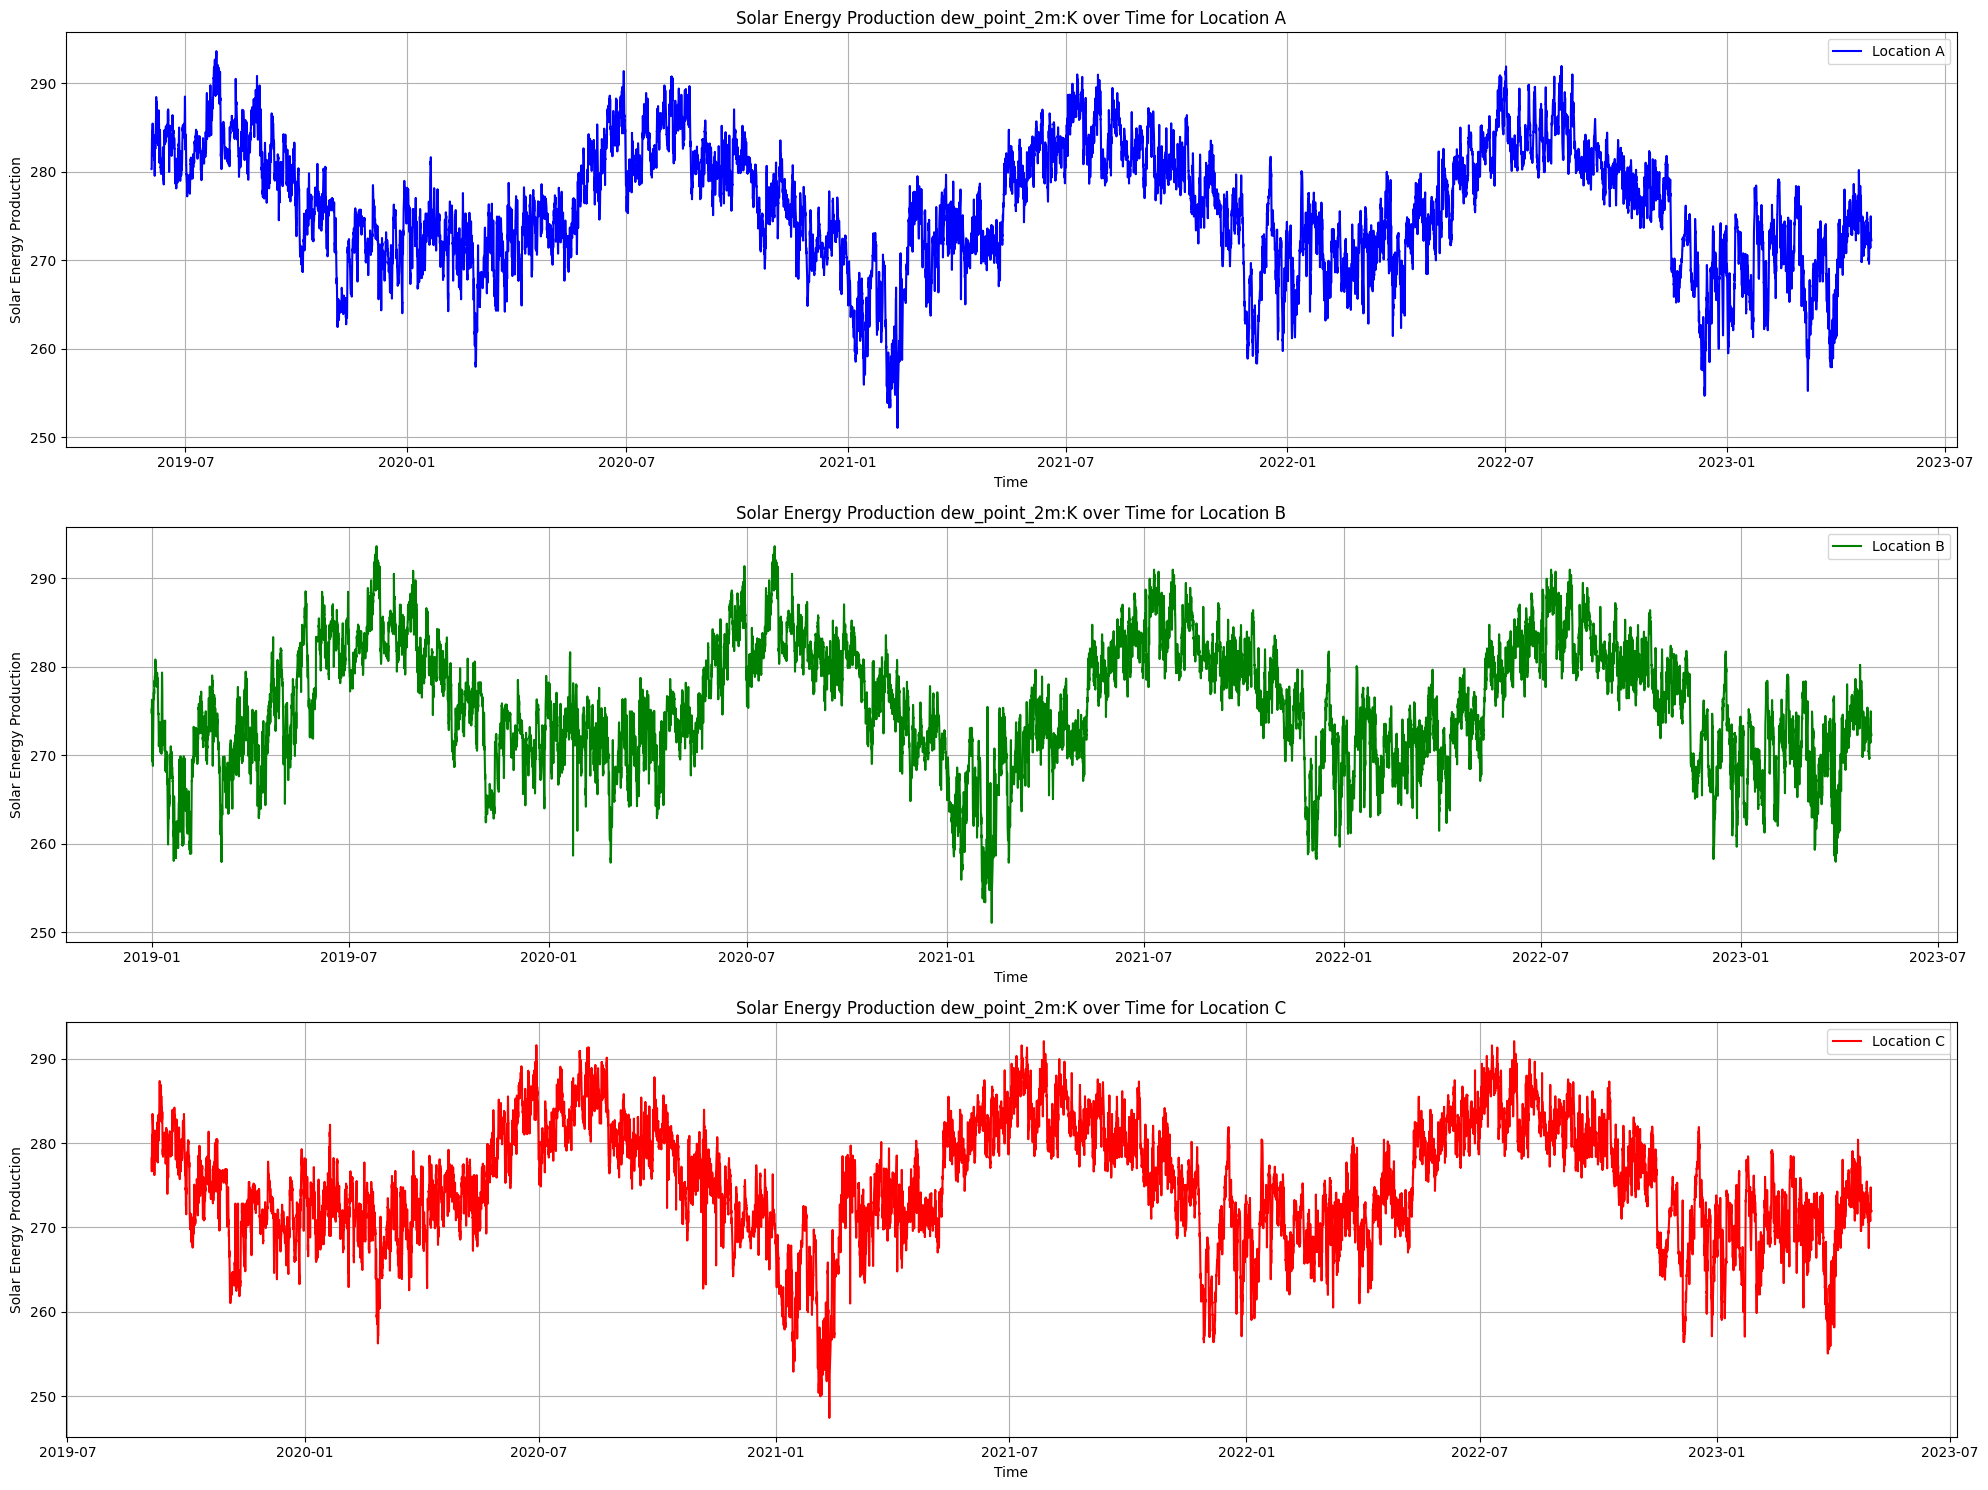

In [11]:
#exploratory data analysis and vizualization 
%matplotlib inline

data_a = x_train_a
data_b = x_train_b
data_c = x_train_c

print(data_b.shape)
print(X_train_observed_b.shape)
print(X_train_estimated_b.shape)


print('Checkpoint 1')

columns = data_a.columns.to_list()

el = columns[7]


# Plotting the pv_measurement over time for locations A, B, and C
print('Checkpoint 2')
plt.figure(figsize=(20, 15))

# Location A
plt.subplot(3, 1, 1)
plt.plot(data_a[el], label='Location A', color='blue')
plt.title(f'Solar Energy Production {el} over Time for Location A')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)

print('Checkpoint 3')

# Location B
plt.subplot(3, 1, 2)
plt.plot(data_b[el], label='Location B', color='green')
plt.title(f'Solar Energy Production {el} over Time for Location B')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)

# Location C
plt.subplot(3, 1, 3)
plt.plot(data_c[el], label='Location C', color='red')
plt.title(f'Solar Energy Production {el} over Time for Location C')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)



plt.tight_layout()

plt.show()




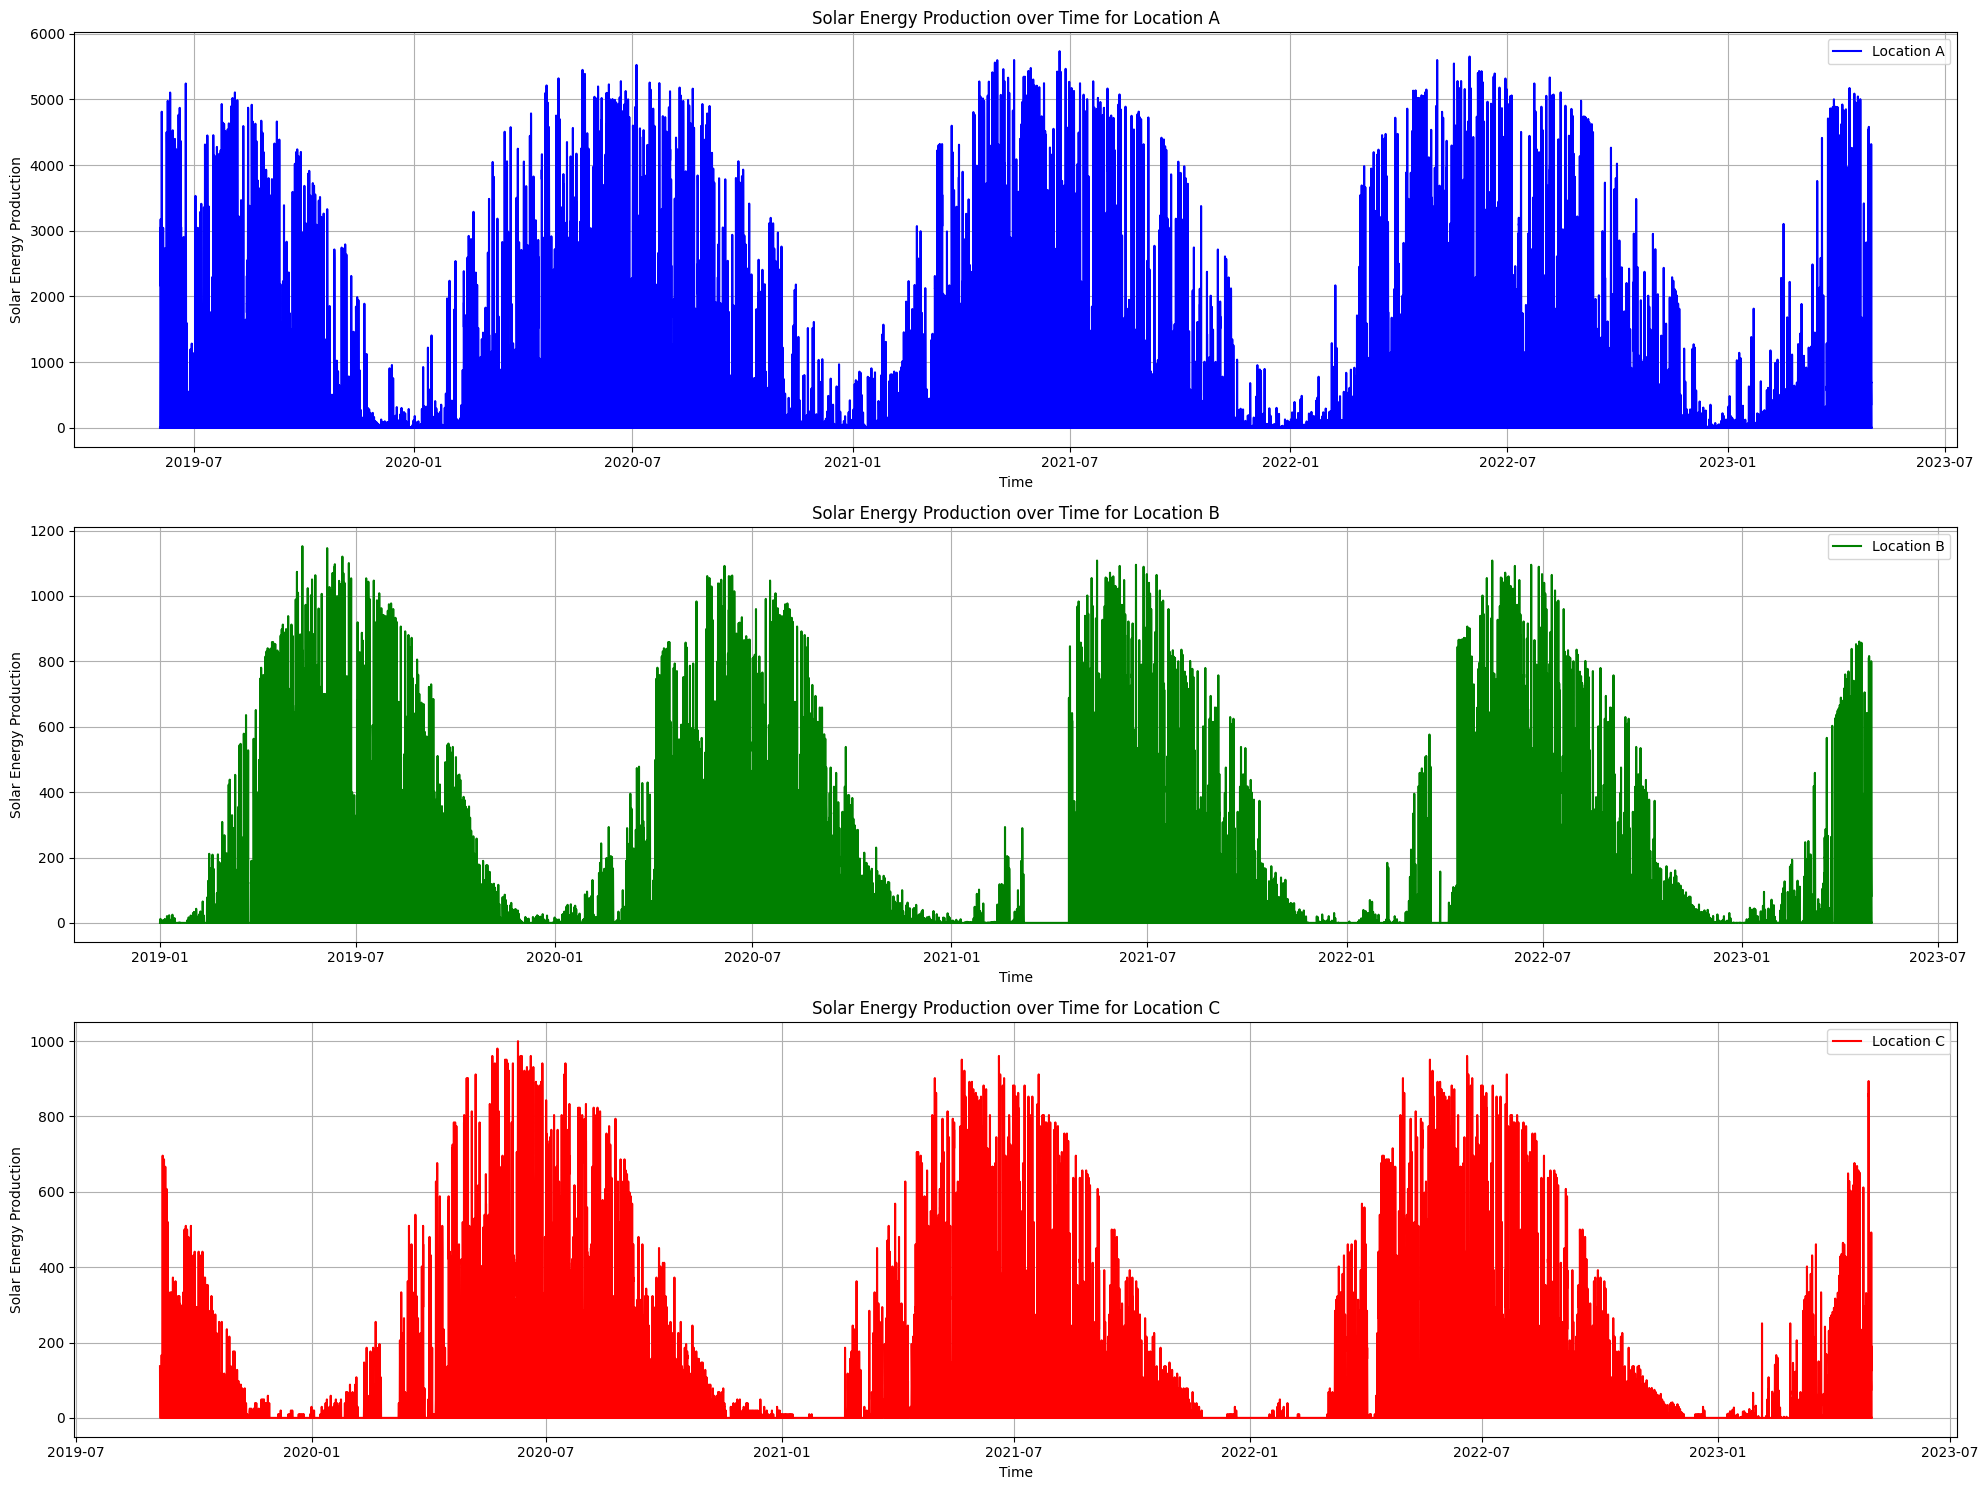

In [4]:
plt.figure(figsize=(20, 15))

# Location A
plt.subplot(3, 1, 1)
plt.plot(x_train_a['pv_measurement'], label='Location A', color='blue')
plt.title(f'Solar Energy Production over Time for Location A')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)

# Location B
plt.subplot(3, 1, 2)
plt.plot(x_train_b['pv_measurement'], label='Location B', color='green')
plt.title(f'Solar Energy Production over Time for Location B')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)

# Location C
plt.subplot(3, 1, 3)
plt.plot(x_train_c['pv_measurement'], label='Location C', color='red')
plt.title(f'Solar Energy Production over Time for Location C')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [3]:
# manual ensemble

from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.estimators import H2ODeepLearningEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init()

# Identify predictors and response
data = h2o.H2OFrame(x_train)
x = data.columns
y = 'pv_measurement'
x.remove(y)


# Number of CV folds (to generate level-one data for stacking)
nfolds = 5

# There are a few ways to assemble a list of models to stack together:
# 1. Train individual models and put them in a list
# 2. Train a grid of models
# 3. Train several grids of models
# Note: All base models must have the same cross-validation folds and
# the cross-validated predicted values must be kept.


# 2. Generate a random grid of models and stack them together

# Specify GBM hyperparameters for the grid
hyper_params_gbm = {"learn_rate": [0.01, 0.03],
                "max_depth": [3, 4, 5, 6, 9],
                "sample_rate": [0.7, 0.8, 0.9, 1.0],
                "col_sample_rate": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}



hyper_params_forest = {"max_depth": [3, 4, 5, 6, 9],
                "sample_rate": [0.7, 0.8, 0.9, 1.0],
                "ntrees": [20, 30, 40, 50, 60, 70]}

hyper_params_nn = {
    "activation": ["Rectifier", "Tanh", "Maxout"],
    "hidden": [[32, 32], [64, 64], [100, 100]],
    "epochs": [10, 20, 30],
}


hyper_params_xgb = {"learn_rate": [0.01, 0.03],
                "max_depth": [3, 4, 5, 6, 9],
                "sample_rate": [0.7, 0.8, 0.9, 1.0],
                "col_sample_rate": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}

search_criteria = {"strategy": "RandomDiscrete", "max_models": 5, "seed": 1}

# Train the grid
grid_gradient = H2OGridSearch(model=H2OGradientBoostingEstimator(distribution="poisson",
                                                        ntrees=10,
                                                        seed=1,
                                                        nfolds=nfolds,
                                                        fold_assignment="Modulo",
                                                        keep_cross_validation_predictions=True),
                     hyper_params=hyper_params_gbm,
                     search_criteria=search_criteria,
                     grid_id="gbm_grid")
grid_gradient.train(x=x, y=y, training_frame=data)

# Train and cross-validate a RF
grid_forest = H2OGridSearch(model=H2ORandomForestEstimator(
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=1),
                    hyper_params=hyper_params_forest,
                    search_criteria=search_criteria,
                    grid_id="forest_grid")
grid_forest.train(x=x, y=y, training_frame=data)

grid_nn = H2OGridSearch(model=H2ODeepLearningEstimator(
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=1),
                    hyper_params=hyper_params_nn,
                    search_criteria=search_criteria,
                    grid_id="nn_grid")
grid_nn.train(x=x, y=y, training_frame=data)


grid_xgb = H2OGridSearch(model=H2OXGBoostEstimator(booster='dart', normalize_type='tree', seed=1234),
                     hyper_params=hyper_params_xgb,
                     search_criteria=search_criteria,
                     grid_id="xgb_grid")
grid_xgb.train(x=x, y=y, training_frame=data)

model_ids = []

if grid_forest is not None:
    model_ids += grid_forest.model_ids
if grid_gradient is not None:
    model_ids += grid_gradient.model_ids
if grid_nn is not None:
    model_ids += grid_nn.model_ids
if grid_xgb is not None:
    model_ids += grid_xgb.model_ids

# Train a stacked ensemble using the GBM grid
ensemble = H2OStackedEnsembleEstimator(model_id="ensemble_gbm_forest_xgb",
                                       base_models=model_ids)
ensemble.train(x=x, y=y, training_frame=data)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmp_z59m9ze
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmp_z59m9ze/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmp_z59m9ze/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months and 1 day
H2O_cluster_name:,H2O_from_python_olelasson_2az9pf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.769 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%
xgboost Grid Build progress: |███████████████████████████████████████████████████| (done) 100%
stackedensemble Model Build progress: | (failed)


OSError: Job with key $03017f00000132d4ffffffff$_bed6377b266d1390201b0ac1e6b14f73 failed with an exception: water.exceptions.H2OIllegalArgumentException: Base model does not use cross-validation: 0
stacktrace: 
water.exceptions.H2OIllegalArgumentException: Base model does not use cross-validation: 0
	at hex.ensemble.StackedEnsemble.checkAndInheritModelProperties(StackedEnsemble.java:483)
	at hex.ensemble.StackedEnsemble$StackedEnsembleDriver.computeImpl(StackedEnsemble.java:767)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:253)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1689)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:976)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1479)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)


In [18]:

best_gradient = grid_gradient.get_grid(sort_by='mae', decreasing=False).models[0]
best_forest = grid_forest.get_grid(sort_by='mae', decreasing=False).models[0]
best_nn = grid_nn.get_grid(sort_by='mae', decreasing=False).models[0]
best_xgb = grid_xgb.get_grid(sort_by='mae', decreasing=False).models[0]


In [41]:
#AutoML H2O

def train(model):
    if model.lower() == 'a':
        automl_df=x_train_a
    elif model.lower() == 'b':
        automl_df=x_train_b
    elif model.lower() == 'c':
        automl_df=x_train_c
    elif model.lower() == 's':
        automl_df=x_train
    else:
        return

    h2o.init()
    train_df = h2o.H2OFrame(automl_df)
    train_df.describe()

    test = h2o.H2OFrame(automl_df)
    x = test.columns
    y = 'pv_measurement'
    x.remove(y)

    # import autoML from H2O
    from h2o.automl import H2OAutoML
    # callh20automl  function
    aml = H2OAutoML(max_runtime_secs = 300,
                    sort_metric='MAE'
    )
    # train model and record time % time
    aml.train(x = x, y = y, training_frame = test)

    leaderboard = aml.leaderboard

    # Obtain the leader model
    best_model_1 = h2o.get_model(leaderboard[0, 'model_id'])
    best_model_2 = h2o.get_model(leaderboard[1, 'model_id'])
    best_model_3 = h2o.get_model(leaderboard[2, 'model_id'])


    # Save the leader model
    model_path_1 = h2o.save_model(model=best_model_1, path="/tmp/mymodel", force=True)
    model_path_2 = h2o.save_model(model=best_model_2, path="/tmp/mymodel", force=True)
    model_path_3 = h2o.save_model(model=best_model_3, path="/tmp/mymodel", force=True)

    # Load the saved model
    loaded_model_1 = h2o.load_model(model_path_1)
    loaded_model_2 = h2o.load_model(model_path_2)
    loaded_model_3 = h2o.load_model(model_path_3)

    # Download the model to local machine
    my_local_model_1 = h2o.download_model(best_model_1, path=f"./models/{model.upper()}")
    my_local_model_2 = h2o.download_model(best_model_2, path=f"./models/{model.upper()}")
    my_local_model_3 = h2o.download_model(best_model_3, path=f"./models/{model.upper()}")

    h2o.cluster().shutdown()

    return my_local_model_1, my_local_model_2, my_local_model_3 

 

In [4]:
my_local_model_all = train('s')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpzle5940n
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpzle5940n/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpzle5940n/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month and 17 days
H2O_cluster_name:,H2O_from_python_olelasson_voc02j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.769 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:89649
Cols:48

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,hour,month,pv_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,int,real
mins,0.5,1.1392500400543213,27.799999237060547,0.0,0.0,27.5,-1.0,247.4250030517578,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.375,0.0,0.0,929.9749755859376,935.75,0.0,0.0,19.575000762939453,941.5499877929688,0.0,0.0,0.0,0.0,0.0,6.982999801635742,-49.93199920654297,0.0,258.0249938964844,0.0,132.375,0.02500000037252903,-7.224999904632568,-8.399999618530273,-0.10000000149011612,0.0,1.0,0.0
mean,5.953513983479484,1.2559042374106844,3242.53184344201,506267.28696217225,140.59968682094058,1897.5800940185081,0.006483619449185156,275.08602496472906,38.81440256158324,139759.74543087342,49.7322078275029,179088.89413974012,66.96945478093551,11.536570402346923,0.12109811584937151,0.010078751638469021,0.23930913867335488,0.030280036615756786,0.06059855657487522,0.4783377394059054,0.5698418275719747,1009.3543455408156,0.00562889713241613,0.08564512710682774,995.6473678273815,1001.780138919689,0.7727269687409546,0.009266974696725527,73.5918250561616,1007.9402228805191,11.625896552108784,0.19515415718481552,2.2309228212249993e-05,0.00028087318077876094,0.08968281939904227,179.7280010696019,-1.5463650727653304,0.056143125873094106,279.3156604604936,73.58820122693096,33198.276191153425,3.031888530815084,0.6323277452099876,0.6984034951126642,-8.365960808141722e-06,11.508795413222682,6.298798648060767,293.12611277746066
maxs,17.350000381469727,1.440999984741211,12294.9013671875,2990595.5,835.6500244140625,11673.625,1.0,293.625,334.75,1198315.125,683.4000244140625,2441810.5,100.0,24.0,37.474998474121094,7.25,37.474998474121094,20.325000762939453,33.375,1.0,1.0,1043.949951171875,0.6225000023841858,5.0,1030.875,1037.25,96.7750015258789,1.100000023841858,100.0,1043.7249755859375,250.0,18.200000762939453,1.0,0.18000000715255737,5.650000095367432,348.4875183105469,49.943748474121094,1.375,303.25,100.0,75489.328125,13.274999618530272,11.199999809265137,8.824999809265137,0.10000000149011612,23.0,12.0,5733.42
sigma,2.686574072724378,0.03663060731661263,2741.3803200438397,813889.0803505486,226.64339684032552,1977.3205785347948,0.23727589293602452,6.809337620825011,60.215639469232336,214232.8099424869,112.61234603783663,400239.2175958297,34.33953964033072,7.961193605660266,0.7932382999947833,0.10682417576577144,1.2435727578284606,0.2801183441882201,0.48550341381593043,0.48580553218617545,0.48243960639764116,13.148971274159113,0.028846995172746092,0.33367245158847764,13.060142980511541,13.119657794613133,5.389750020012358,0.040624161212337556,14.241539281444648,13.181300979550857,52.643552128015244,1.2492053068455655,0.0042574584447524705,0.004294417160548521,0.23654618689770454,97.2730545068924,24.0061927343051,0.105180288245308,6.50329177657943,34.121903894889385,17882.577079085786,1.7500052190670394,2.7934802755487573,1.8780588527746538,0.006090109764186484,6.924730545256264,3.617721851332757,779.8272073565429
zeros,0,0,0,40140,43896,0,83361,0,43915,40148,50551,45996,3296,0,83973,87853,80978,86944,8584

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
H2O session _sid_8376 closed.


In [42]:
my_local_model_A1, my_local_model_A2, my_local_model_A3 = train('a')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpov3nrmbr
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpov3nrmbr/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpov3nrmbr/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months
H2O_cluster_name:,H2O_from_python_olelasson_f2936q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.769 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:34060
Cols:46

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,pv_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,0.699999988079071,1.1449999809265137,27.849998474121097,0.0,0.0,27.799999237060547,-1.0,251.0749969482422,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.4000244140624,0.0,0.0,932.4000244140624,938.2000122070312,0.0,0.0,21.700000762939453,944.0,0.0,0.0,0.0,0.0,0.0,6.982999801635742,-49.89399719238281,0.0,259.0,0.0,159.6750030517578,0.02500000037252903,-7.224999904632568,-8.399999618530273,0.0,0.0
mean,6.322295949724024,1.2532794770358673,2974.2150833648975,552658.5415879489,153.514649874559,1728.9423052403902,0.020669406928948912,275.9717321663555,42.067516881340055,151444.66423718008,52.628560648108746,189463.45519622616,67.70116415447029,6.0,0.08820537283920359,0.007403112218304548,0.1736002643376641,0.022290076366262068,0.04440619494838183,0.49917058132706926,0.5353640634174985,1009.6033969039147,0.006014826759399068,0.08907809747504387,996.7071279134883,1002.8286479132354,0.2318922490170811,0.010783176933356717,74.02495301319992,1008.9773758463202,8.367586611861421,0.07351071664547254,0.0,0.0001272753942664877,0.08968951931415783,179.63809271897568,-0.0474838873134131,0.05566426996366975,279.93644524673397,74.31825237787592,32578.064199441527,3.061284496800733,0.6571095131847896,0.5701475332548509,1.688197324040422e-05,630.9999468584856
maxs,17.350000381469727,1.4262499809265137,12294.9013671875,2988627.5,835.0999755859375,11673.625,1.0,293.625,332.2749938964844,1191085.25,683.4000244140625,2441749.5,100.0,6.0,15.0,3.549999952316284,15.0,7.875,14.225000381469728,1.0,1.0,1043.949951171875,0.6225000023841858,3.75,1030.875,1037.25,91.875,1.100000023841858,100.0,1043.7249755859375,250.0,6.300000190734863,0.0,0.13249999284744263,5.650000095367432,348.48651123046875,49.90550231933594,1.2999999523162842,303.25,100.0,69395.5234375,13.274999618530272,11.199999809265137,8.25,0.10000000149011612,5733.42
sigma,2.7994798278883954,0.03720695091490526,2564.664123481157,848348.2058312666,236.24636904778754,1807.1632209512609,0.1852996710739686,6.892405036402572,62.83781968438305,223524.28857853572,115.25213904825448,409350.9113340117,33.80864830481898,0.0,0.5945348853878387,0.08363688051188617,0.9281891297295519,0.21411651259412595,0.3667185722909611,0.4861567320260638,0.48665442100994316,12.739058771123537,0.03021821234982142,0.3236933092818662,12.60315755349742,12.659424166075002,2.8032978669484723,0.043945586078858755,13.881197810510436,12.717865980257425,44.965981711816575,0.4684943168697462,0.0,0.002648581022942395,0.23755095116384928,97.65903453208804,24.15524100694911,0.10392013958294163,6.665025197866818,33.49255695768445,17701.766321017632,1.7749995126717804,2.88972254724393,1.83716736733841,0.0011572822548863207,1166.2213480859334
zeros,0,0,0,14533,15958,0,32519,0,15966,14536,18178,16399,1091,0,32397,33531,31466,33267,32947,15952,14818,0,30324,30324,0,0,33462,30967,0,0,32920,32920,34060,33930,22537,0,0,22079,0,1091,0,0,153,212,34050,16023
missing,0,0,6127,0,0,2363,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
14:26:03.619: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

███████
14:26:34.946: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█
14:26:38.17: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█████
14:27:01.48: _train param, Dropping unused columns: [snow_drift:idx, elevation:m]


14:27:01.793: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

████
14:27:21.402: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

████████
14:27:59.13: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

███
14:28:14.864: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█████
14:28:38.32: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

████
14:28:57

In [43]:
my_local_model_B1, my_local_model_B2, my_local_model_B3 = train('b')


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpxuhbdllz
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpxuhbdllz/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpxuhbdllz/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months
H2O_cluster_name:,H2O_from_python_olelasson_0ostzu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.769 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:29662
Cols:46

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,pv_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,0.699999988079071,1.1514999866485596,27.849998474121097,0.0,0.0,27.975000381469727,-1.0,251.0500030517578,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.5,0.0,0.0,932.2999877929688,938.0499877929688,0.0,0.0,19.575000762939453,943.8499755859376,0.0,0.0,0.0,0.0,0.0,6.983749866485596,-49.89324951171875,0.0,259.0249938964844,0.0,174.72500610351562,0.05000000074505806,-7.224999904632568,-7.599999904632568,0.0,0.0
mean,5.734117726338912,1.25815957274651,2689.3791801293273,488685.627690896,135.7598214918748,1733.0352848005227,0.008259726249072884,274.5889943418461,37.719902562129704,135787.5693706036,49.46330826420748,178026.95969889764,66.60262289244841,7.0,0.10023936339870106,0.008186400164247532,0.19823343007407773,0.024747151211677778,0.049828062798268034,0.4702228440428829,0.5655383992987655,1009.1178999396624,0.005335783146242149,0.08309453172409158,996.0508082756807,1002.1947744432659,0.06101999144143887,0.00805744737999338,72.95242058474432,1008.3661816030933,13.190277122243948,0.333338110124517,6.742633672712562e-05,0.0003093183181281195,0.08766435252953575,179.76084631150545,-2.16605494332942,0.05482266973940204,278.82670753555595,73.20619733381916,33699.2586843313,3.1274619033700484,0.575498955259864,0.6024298760720967,2.69705351555382e-05,93.73000250780663
maxs,17.350000381469727,1.4254999160766602,12285.775390625,2988610.25,835.0999755859375,11636.0986328125,1.0,293.6000061035156,332.2749938964844,1129488.75,683.4000244140625,2441810.5,100.0,7.0,12.25,3.125,14.975000381469728,7.875,12.25,1.0,1.0,1041.375,0.5849999785423279,3.75,1027.925048828125,1034.300048828125,73.0999984741211,0.8999999761581421,100.0,1040.75,250.0,18.200000762939453,1.0,0.18000000715255737,3.549999952316284,348.4875183105469,49.90550231933594,1.2999999523162842,303.25,100.0,68500.0,13.274999618530272,11.199999809265137,8.225000381469727,0.10000000149011612,1152.3
sigma,2.5773752477046963,0.03496031733706205,2378.783759300862,802589.4830049634,223.52946350196768,1694.9161662630975,0.11126896124218592,6.599904290528785,59.28577362680563,210941.4778530745,112.947629872254,401516.78679421055,34.35217249576653,0.0,0.6239167683710348,0.08024323973891644,1.0411980698789893,0.20960040565046256,0.36542141064258815,0.48550816295107785,0.4833404546173719,13.338192419632149,0.02705582782794129,0.33477597797248193,13.214763939596413,13.274757002311356,1.2690021201913835,0.03759472554763306,14.331169992125288,13.33677950443812,55.889991765306654,1.8608212053736313,0.007401432234891735,0.004920859827797779,0.23016856408419917,96.99805342372467,24.004380894041873,0.10376174165244344,6.454528561836491,34.17728565150571,17730.94300517098,1.8003882788174195,2.9696363565472144,1.8635582446842984,0.001480102180294611,201.82151555813627
zeros,0,0,0,13528,14772,0,29159,0,14775,13529,16620,15140,1127,0,27998,29116,27185,28849,28530,14767,12005,0,27040,27040,0,0,29491,27630,0,0,28097,28097,29659,29449,19618,0,1,19406,0,1127,0,0,134,185,29

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
14:31:25.624: _train param, Dropping bad and constant columns: [elevation:m]

████████
14:32:01.735: _train param, Dropping bad and constant columns: [elevation:m]

█
14:32:04.980: _train param, Dropping bad and constant columns: [elevation:m]

█████
14:32:30.19: _train param, Dropping unused columns: [elevation:m]
14:32:30.719: _train param, Dropping bad and constant columns: [elevation:m]

████
14:32:51.359: _train param, Dropping bad and constant columns: [elevation:m]

████████
14:33:27.490: _train param, Dropping bad and constant columns: [elevation:m]

██
14:33:39.233: _train param, Dropping bad and constant columns: [elevation:m]

███
14:33:53.674: _train param, Dropping bad and constant columns: [elevation:m]

█████
14:34:14.111: _train param, Dropping unused columns: [elevation:m]
14:34:14.689: _train param, Dropping unused columns: [elevation:m]
14:34:15.173: _tra

In [44]:
my_local_model_C1, my_local_model_C2, my_local_model_C3 = train('c')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpu2vtlfbk
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpu2vtlfbk/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpu2vtlfbk/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months
H2O_cluster_name:,H2O_from_python_olelasson_r5mrbk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.769 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:25927
Cols:46

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,pv_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,0.5,1.1392500400543213,27.799999237060547,0.0,0.0,27.5,-1.0,247.4250030517578,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.375,0.0,0.0,929.9749755859376,935.75,0.0,0.0,21.325000762939453,941.5499877929688,0.0,0.0,0.0,0.0,0.0,6.982999801635742,-49.93199920654297,0.0,258.0249938964844,0.0,132.375,0.05000000074505806,-6.300000190734863,-7.875,-0.10000000149011612,0.0
mean,5.720051492987504,1.2567721196043413,2976.3336753354906,465438.07589844026,129.17053743167497,1755.6421613203267,-0.014184055231997547,274.49111367721224,35.79299573676265,128953.80381622132,46.23493941143597,166674.86821311395,66.42789371385155,24.0,0.1881725611040521,0.015758668639246572,0.37262313290119986,0.0471062985416866,0.09419234773467332,0.4602537894858634,0.6200582404443249,1009.2976772025705,0.0054572453394147865,0.08405330350599766,993.7936138600799,999.9283575635554,2.297449571219194,0.008658927143566674,73.75434587285683,1006.0904054066823,14.116558028310255,0.19686523724315613,0.0,0.0004501099202608202,0.09198326160888064,179.80853575764806,-2.806466597655211,0.0582828721650896,279.0595333281668,73.06617620576732,33439.88832233183,2.883929878514518,0.6647876730951603,0.9766912857887324,-8.196089184405602e-05,77.38594361090747
maxs,15.925000190734863,1.440999984741211,12260.224609375,2990595.5,835.6500244140625,11652.7001953125,1.0,292.07501220703125,334.75,1198315.125,682.3250122070312,2437657.75,100.0,24.0,37.474998474121094,7.25,37.474998474121094,20.325000762939453,33.375,1.0,1.0,1043.9000244140625,0.6075000166893005,5.0,1028.300048828125,1034.64990234375,96.7750015258789,0.699999988079071,100.0,1041.0999755859375,250.0,11.600000381469728,0.0,0.17000000178813934,3.549999952316284,348.47698974609375,49.943748474121094,1.375,302.8999938964844,100.0,75489.328125,12.425000190734863,10.024999618530272,8.824999809265137,0.10000000149011612,999.6
sigma,2.602672189843556,0.03751239978604706,2632.2559074052847,776703.0434404379,216.2379239893735,1909.4805731295144,0.36702755064191483,6.813310226020598,57.489471124615584,204554.80893785553,108.54700161262417,386062.557120703,34.995432194988275,0.0,1.1223371884134543,0.1511851818256167,1.7175599515236684,0.400540647085451,0.6957115721995945,0.4847006092754559,0.4714870671236883,13.452394416526607,0.028983586556109248,0.34510044903392756,13.275583333833433,13.34058630442009,9.21919366109367,0.03933795165247809,14.57666930258998,13.407766933551832,57.70607189620233,1.0511335162433586,0.0,0.0051759137970474045,0.24233863414962312,97.08263169651204,23.707219383976003,0.10836107373779998,6.275004948217094,34.85439513786871,18264.47227811209,1.6458683908717706,2.4328108104602713,1.9181846117744932,0.011134449605428894,165.77915435302563
zeros,0,0,0,12079,13166,0,21683,0,13174,12083,15753,14457,1078,0,23578,25206,22327,24828,24369,13165,9023,0,23691,23691,0,0,23012,24047,0,0,24463,24463,25927,25600,17032,0,0,16606,0,1070,0,0,224,122,25475,15935
missing,0,0,5117,0,0,2200,0,

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
14:36:49.509: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█████████
14:37:27.14: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]


14:37:29.980: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

████
14:37:50.230: _train param, Dropping unused columns: [snow_drift:idx, elevation:m]

█
14:37:50.870: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

███
14:38:09.635: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

███████
14:38:43.61: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

████
14:38:59.236: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██
14:39:11.193: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

███
14:39:25.8

In [40]:
models = [best_forest, best_gradient, best_nn, best_xgb]

x_test_a = preprocessing_X_test(X_test_estimated_a)
est_test_a = h2o.H2OFrame(x_test_a)
x_test_b = preprocessing_X_test(X_test_estimated_b)
est_test_b = h2o.H2OFrame(x_test_b)
x_test_c = preprocessing_X_test(X_test_estimated_c)
est_test_c = h2o.H2OFrame(x_test_c)

master_a_df = pd.DataFrame()
master_b_df = pd.DataFrame()
master_c_df = pd.DataFrame()

count = 0

for model in models:

    preds_a_df = model.predict(est_test_a).as_data_frame()
    master_a_df[f'prediction_{count}'] = preds_a_df
    
    preds_b_df = model.predict(est_test_b).as_data_frame()
    master_b_df[f'prediction_{count}'] = preds_b_df

    
    preds_c_df = model.predict(est_test_c).as_data_frame()
    master_c_df[f'prediction_{count}'] = preds_c_df
    count += 1

print(master_c_df)
master_a_df['prediction'] = master_a_df[['prediction_0','prediction_1','prediction_2','prediction_3']].mean(axis=1)

master_b_df['prediction'] = master_b_df[['prediction_0','prediction_1','prediction_2','prediction_3']].mean(axis=1)

master_c_df['prediction'] = master_c_df[['prediction_0','prediction_1','prediction_2','prediction_3']].mean(axis=1)


final_df = pd.concat([master_a_df['prediction'], master_b_df['prediction'], master_c_df['prediction']], axis=0, ignore_index=True).to_frame()
print(final_df.columns)

final_df['prediction'] = final_df['prediction'].apply(lambda x: 0.0 if x < 5 else x)
final_df.rename(columns={'predict':'prediction'})


# Set the index name to 'id'
final_df.index.name = 'id'

# Save to a CSV file
final_df.to_csv('predictions_v30_29under5.csv')







Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |███████████████

Index(['id', 'prediction'], dtype='object')
Index(['id', 'predict'], dtype='object')


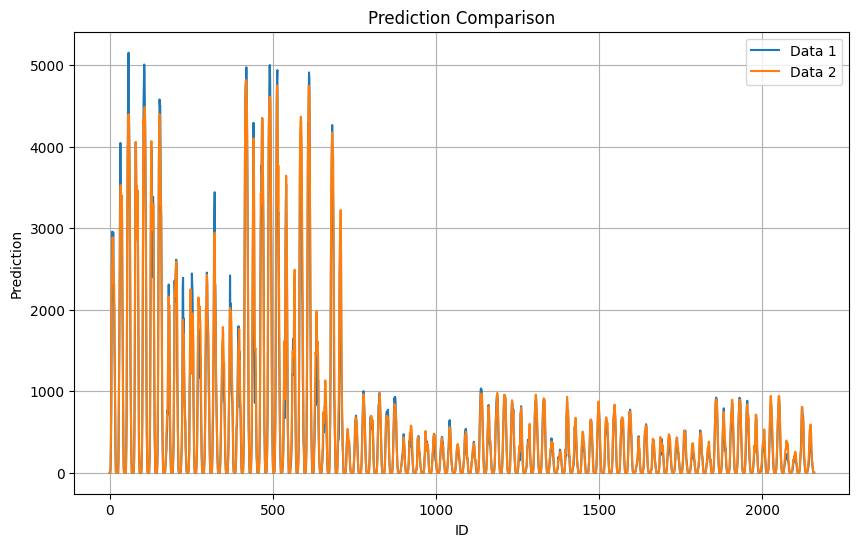

In [12]:
df1 = pd.read_csv("predictions_v16.csv")
df2 = pd.read_csv("predictions_v27.csv")

print(df1.columns)
print(df2.columns)

plt.figure(figsize=(10, 6))  # Set the size of the plot

plt.plot(df1['id'], df1['prediction'], label='Data 1', linestyle='-')
plt.plot(df2['id'], df2['predict'], label='Data 2', linestyle='-')

plt.xlabel('ID')
plt.ylabel('Prediction')
plt.title('Prediction Comparison')
plt.legend()

plt.grid(True)
plt.show()







In [49]:

h2o.init()
model_a1 = h2o.upload_model(my_local_model_A1)
model_a2 = h2o.upload_model(my_local_model_A2)
model_a3 = h2o.upload_model(my_local_model_A3)
#model = h2o.get_model(model_a)


x_test_a = preprocessing_X_test(X_test_estimated_a)

est_test_a = h2o.H2OFrame(x_test_a)

preds_a1 = model_a1.predict(est_test_a)
preds_df_a1 = preds_a1.as_data_frame()
preds_a2 = model_a2.predict(est_test_a)
preds_df_a2 = preds_a2.as_data_frame()
preds_a3 = model_a3.predict(est_test_a)
preds_df_a3 = preds_a3.as_data_frame()


model_b1 = h2o.upload_model(my_local_model_B1)
model_b2 = h2o.upload_model(my_local_model_B2)
model_b3 = h2o.upload_model(my_local_model_B3)
#model = h2o.get_model(model_b)

x_test_b = preprocessing_X_test(X_test_estimated_b)

est_test_b = h2o.H2OFrame(x_test_b)

preds_b1 = model_b1.predict(est_test_b)
preds_df_b1 = preds_b1.as_data_frame()
preds_b2 = model_b2.predict(est_test_b)
preds_df_b2 = preds_b2.as_data_frame()
preds_b3 = model_b3.predict(est_test_b)
preds_df_b3 = preds_b3.as_data_frame()


model_c1 = h2o.upload_model(my_local_model_C1)
model_c2 = h2o.upload_model(my_local_model_C2)
model_c3 = h2o.upload_model(my_local_model_C3)
#model = h2o.get_model(model_c)

x_test_c = preprocessing_X_test(X_test_estimated_c)

est_test_c = h2o.H2OFrame(x_test_c)

preds_c1 = model_c1.predict(est_test_c)
preds_df_c1 = preds_c1.as_data_frame()
preds_c2 = model_c2.predict(est_test_c)
preds_df_c2 = preds_c2.as_data_frame()
preds_c3 = model_c3.predict(est_test_c)
preds_df_c3 = preds_c3.as_data_frame()





Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 min 36 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months
H2O_cluster_name:,H2O_from_python_olelasson_mx0ige
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.374 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |████████████

In [50]:


preds_df_a = pd.DataFrame()

# Calculate mean for group A
preds_df_a['prediction'] = (preds_df_a1['predict'] + preds_df_a2['predict'] + preds_df_a3['predict']) / 3
preds_df_a['prediction'] = preds_df_a['prediction'].apply(lambda x: 0.0 if x < 5 else x)


preds_df_b = pd.DataFrame()

# Calculate mean for group B
preds_df_b['prediction'] = (preds_df_b1['predict'] + preds_df_b2['predict'] + preds_df_b3['predict']) / 3
preds_df_b['prediction'] = preds_df_b['prediction'].apply(lambda x: 0.0 if x < 5 else x)


preds_df_c = pd.DataFrame()
# Calculate mean for group C
preds_df_c['prediction'] = (preds_df_c1['predict'] + preds_df_c2['predict'] + preds_df_c3['predict']) / 3
preds_df_c['prediction'] = preds_df_c['prediction'].apply(lambda x: 0.0 if x < 5 else x)




# Combine DataFrames
final_df = pd.concat([preds_df_a, preds_df_b, preds_df_c], axis=0, ignore_index=True)

# Set the index name to 'id'
final_df.index.name = 'id'

# Save to a CSV file
final_df.to_csv('predictions_v26.csv')
